In [1]:
using PyPlot
using FileIO
using JLD2

In [2]:
;ls

U-b55_s15.jld2
cov.txt
data.csv
params.txt
run2_U-b55_s15.jld2
sims.ipynb


In [3]:
sim_one = load("U-b55_s15.jld2")["results_dict"];
sim_two = load("run2_U-b55_s15.jld2")["results_dict"];
cov = vcat(readdlm("cov.txt")...);
NS=20;

In [4]:
for key in keys(sim_one)
    println(key, '\t', size(sim_two[key]))
end

sigma_results	(1000, 2)
sigma_used	(1000, 2)
beta_results	(1000, 3)
beta_used	(1000, 3)
h_results	(2, 2, 20, 1000)
x_results	(2, 20, 1000)
l_results	(1000, 20)


In [5]:
function lml(x, l, h)
    nparam, nsub = size(x)
    return -nparam/2*log(2*pi)*nsub + sum(l) - sum([log(det(h[:, :, i])) for i in 1:nsub])/2
end

function computemeans(X,betas)
    nparam = size(X,1)
    nsub = size(X,3)

    mu = zeros(typeof(betas[1]),nparam,nsub)
    for i = 1:nsub
        mu[:,i] = X[:,:,i] * betas;
    end

    return mu
end

function freeenergy(x,l,h,X,betas,sigma)
    nsub = size(X,3)
    nbetas = size(X,2)
    nparam = size(X,1)

    if length(size(sigma)) < 2
        sigma = diagm(sigma)
    end
    mu = computemeans(X,betas)
    
    if (any([det(h[:,:,i]) for i in 1:nsub] .< 0) || det(sigma) < 0)
        return NaN
    else
        return (sum([(
        # MVN Log L (from Wikipedia) terms not involving subject level params x
        -nparam/2*log(2*pi) - 1/2 * log(det(sigma)) -
        # MVN LogL term involving x, in expectation over x from Eq 7a in Roweis cheat sheet
        1/2 * ((x[:,sub]-mu[:,sub])' * inv(sigma) * (x[:,sub]-mu[:,sub]) + trace(inv(sigma) * h[:,:,sub] )) +
        # entropy of hidden variables (from Wikipedia)
        nparam/2*log(2*pi*e) + 1/2 * log(det(h[:,:,sub])))
        for sub in 1:nsub])[1]
        # expected LL for the observations
        - lml(x,l,h))
    end
end

function designmatrix(X)
    nparam = length(X)
    nsub = size(X[1],1)
    nreg = sum([length(X[i][1,:]) for i in 1:nparam])

    X2 = zeros(nparam,nreg,nsub)
    for i =1 :nsub
        n = 1
        for j = 1:nparam
            l = length(X[j][i,:])
            X2[j,n:(n+l-1),i] = X[j][i,:]
            n += l
        end
    end

    return(X2)
end

designmatrix (generic function with 1 method)

In [6]:
function get_metrics(data, cov, NS)
    NSIM = size(data[:sigma_used], 1)
    lml_storage = Array{Float64}(NSIM)
    fe_storage = Array{Float64}(NSIM)
    X = designmatrix(Any[[ones(NS) cov], ones(NS)])
    
    for sim in 1:NSIM
        try
            lml_storage[sim] = lml(
                data[:x_results][:, :, sim],
                data[:l_results][sim, :],
                data[:h_results][:, :, :, sim]
            )
            fe_storage[sim] = freeenergy(
                data[:x_results][:, :, sim],
                data[:l_results][sim, :],
                data[:h_results][:, :, :, sim],
                X,
                data[:beta_results][sim, :],
                data[:sigma_results][sim, :]
            )
        catch
            lml_storage[sim] = 0.
            fe_storage[sim] = 0.
        end
    end
    
    return Dict(:lml => lml_storage, :fe => fe_storage)
end

get_metrics (generic function with 1 method)

In [7]:
sim_one_lf = get_metrics(sim_one, cov, NS);
sim_two_lf = get_metrics(sim_two, cov, NS);

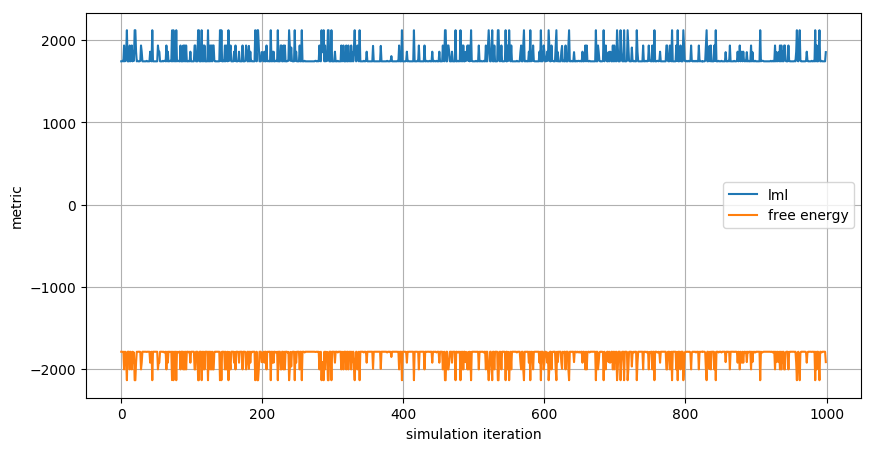

PyObject <matplotlib.legend.Legend object at 0x132f50410>

In [8]:
plt[:figure](figsize=(10, 5))
plot(sim_one_lf[:lml])
plot(sim_one_lf[:fe])
plt[:grid](true, which="both")
xlabel("simulation iteration")
ylabel("metric")
legend(["lml", "free energy"])

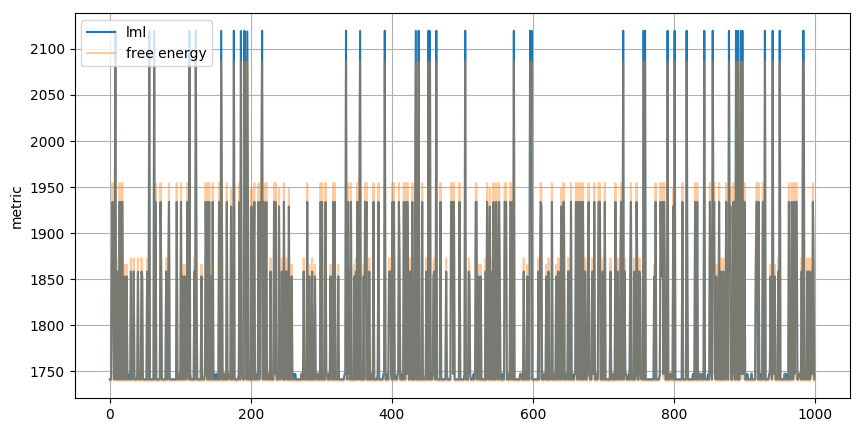

PyObject <matplotlib.legend.Legend object at 0x10b5e0910>

In [18]:
plt[:figure](figsize=(10, 5))
plot(sim_two_lf[:lml])
plot(sim_two_lf[:fe] .* -1 .-50, alpha=.4)
plt[:grid](true, which="both")
ylabel("metric")
legend(["lml", "free energy"])

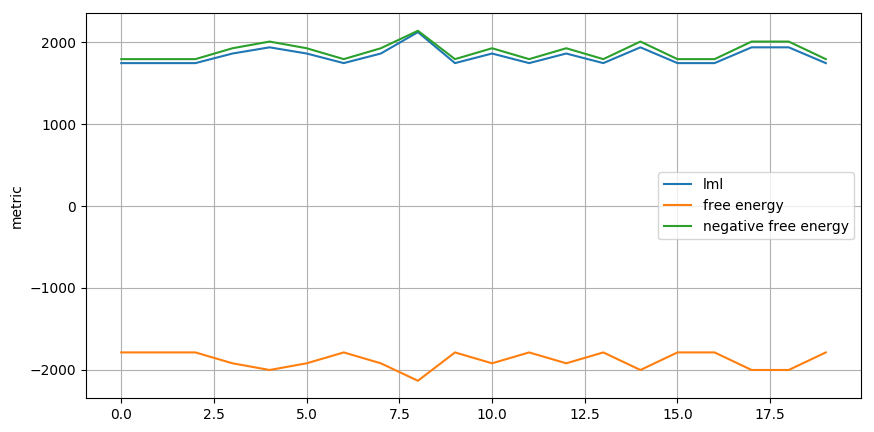

PyObject <matplotlib.legend.Legend object at 0x1333c1450>

In [10]:
plt[:figure](figsize=(10, 5))
plot(sim_two_lf[:lml][1:20])
plot(sim_two_lf[:fe][1:20])
plot(sim_two_lf[:fe][1:20] .* -1)
plt[:grid](true, which="both")
ylabel("metric")
legend(["lml", "free energy", "negative free energy"])

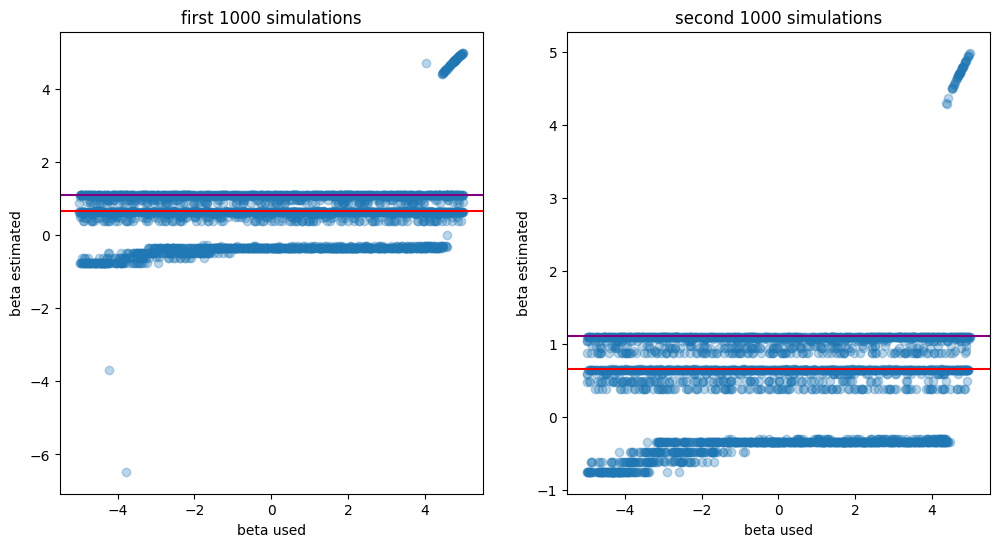

PyObject <matplotlib.lines.Line2D object at 0x133847d10>

In [11]:
nrow, ncol = 1, 2
fig, axe = subplots(nrow, ncol, figsize=(12,6))

axe[1, 1][:scatter](vcat(sim_one[:beta_used]...), vcat(sim_one[:beta_results]...), alpha=.3)
axe[1, 1][:set_xlabel]("beta used")
axe[1, 1][:set_ylabel]("beta estimated")
axe[1, 1][:set_title]("first 1000 simulations")
axe[1, 1][:axhline](.65, color="red")
axe[1, 1][:axhline](1.1, color="purple")

axe[2, 1][:scatter](vcat(sim_two[:beta_used]...), vcat(sim_two[:beta_results]...), alpha=.3)
axe[2, 1][:set_xlabel]("beta used")
axe[2, 1][:set_ylabel]("beta estimated")
axe[2, 1][:set_title]("second 1000 simulations")
axe[2, 1][:axhline](.65, color="red")
axe[2, 1][:axhline](1.1, color="purple")

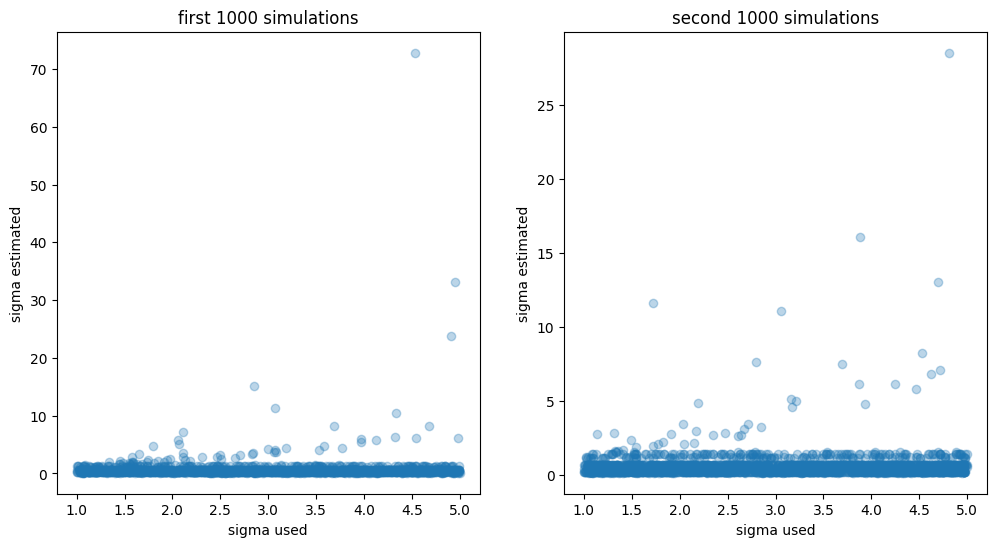

PyObject Text(0.5,1,u'second 1000 simulations')

In [12]:
nrow, ncol = 1, 2
fig, axe = subplots(nrow, ncol, figsize=(12,6))

axe[1, 1][:scatter](vcat(sim_one[:sigma_used]...), vcat(sim_one[:sigma_results]...), alpha=.3)
axe[1, 1][:set_xlabel]("sigma used")
axe[1, 1][:set_ylabel]("sigma estimated")
axe[1, 1][:set_title]("first 1000 simulations")

axe[2, 1][:scatter](vcat(sim_two[:sigma_used]...), vcat(sim_two[:sigma_results]...), alpha=.3)
axe[2, 1][:set_xlabel]("sigma used")
axe[2, 1][:set_ylabel]("sigma estimated")
axe[2, 1][:set_title]("second 1000 simulations")

# estimated betas plotted against fit metrics

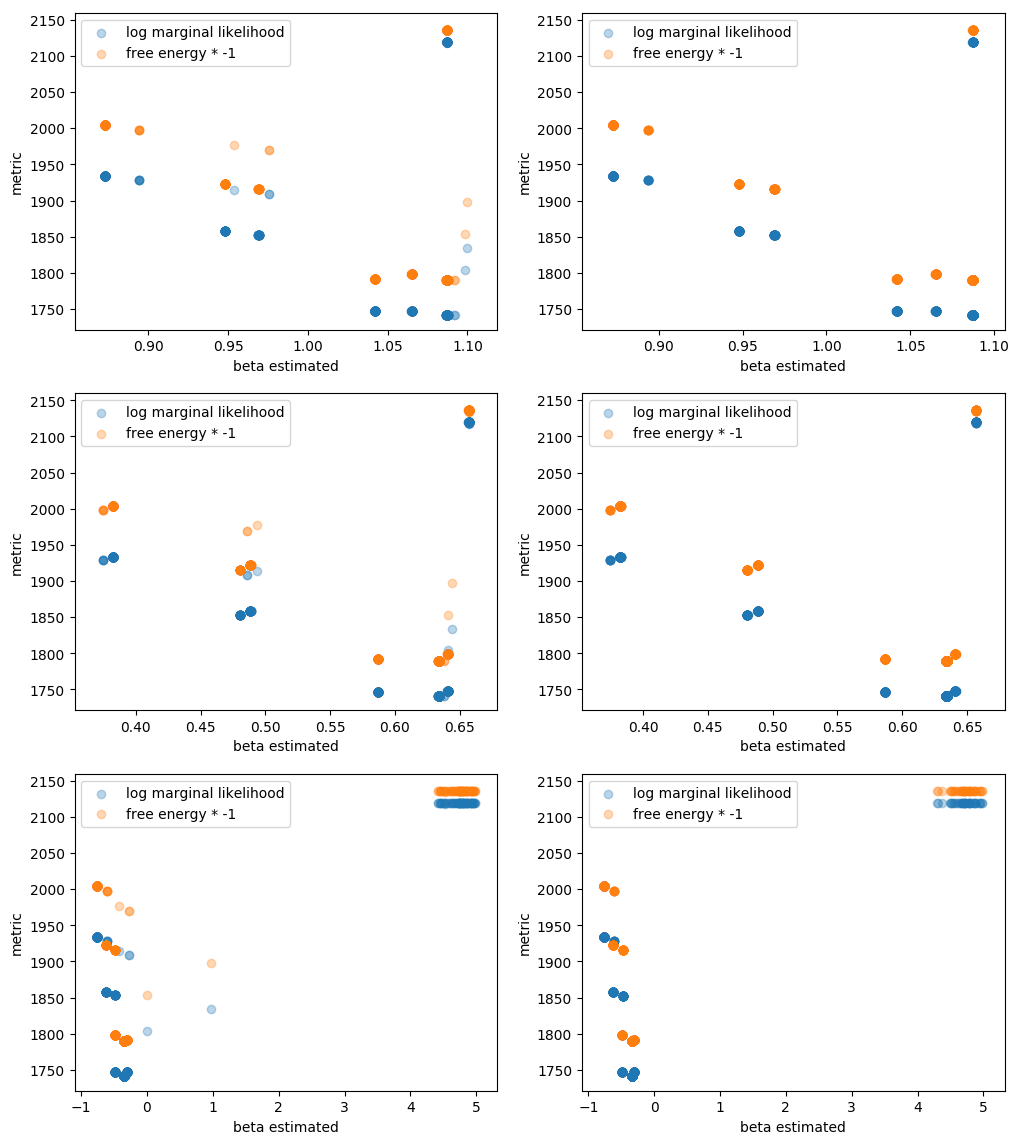

PyObject <matplotlib.legend.Legend object at 0x134001290>

In [13]:
nrow, ncol = (3, 2)
fig, axe = subplots(nrow, ncol, figsize=(12, 14))

axe[1, 1][:scatter](sim_one[:beta_results][:, 1], sim_one_lf[:lml], alpha=.3)
axe[1, 1][:set_xlabel]("beta estimated")
axe[1, 1][:set_ylabel]("metric")
axe[1, 1][:scatter](sim_one[:beta_results][:, 1], sim_one_lf[:fe].*-1, alpha=.3)
axe[1, 1][:legend](["log marginal likelihood", "free energy * -1"])

axe[2, 1][:scatter](sim_one[:beta_results][:, 2], sim_one_lf[:lml], alpha=.3)
axe[2, 1][:set_xlabel]("beta estimated")
axe[2, 1][:set_ylabel]("metric")
axe[2, 1][:scatter](sim_one[:beta_results][:, 2], sim_one_lf[:fe].*-1, alpha=.3)
axe[2, 1][:legend](["log marginal likelihood", "free energy * -1"])

axe[3, 1][:scatter](sim_one[:beta_results][:, 3], sim_one_lf[:lml], alpha=.3)
axe[3, 1][:set_xlabel]("beta estimated")
axe[3, 1][:set_ylabel]("metric")
axe[3, 1][:scatter](sim_one[:beta_results][:, 3], sim_one_lf[:fe].*-1, alpha=.3)
axe[3, 1][:legend](["log marginal likelihood", "free energy * -1"])

# sim 2
axe[1, 2][:scatter](sim_two[:beta_results][:, 1], sim_two_lf[:lml], alpha=.3)
axe[1, 2][:set_xlabel]("beta estimated")
axe[1, 2][:set_ylabel]("metric")
axe[1, 2][:scatter](sim_two[:beta_results][:, 1], sim_two_lf[:fe].*-1, alpha=.3)
axe[1, 2][:legend](["log marginal likelihood", "free energy * -1"])

axe[2, 2][:scatter](sim_two[:beta_results][:, 2], sim_two_lf[:lml], alpha=.3)
axe[2, 2][:set_xlabel]("beta estimated")
axe[2, 2][:set_ylabel]("metric")
axe[2, 2][:scatter](sim_two[:beta_results][:, 2], sim_two_lf[:fe].*-1, alpha=.3)
axe[2, 2][:legend](["log marginal likelihood", "free energy * -1"])

axe[3, 2][:scatter](sim_two[:beta_results][:, 3], sim_two_lf[:lml], alpha=.3)
axe[3, 2][:set_xlabel]("beta estimated")
axe[3, 2][:set_ylabel]("metric")
axe[3, 2][:scatter](sim_two[:beta_results][:, 3], sim_two_lf[:fe].*-1, alpha=.3)
axe[3, 2][:legend](["log marginal likelihood", "free energy * -1"])

# estimated sigmas plotted against fit metrics

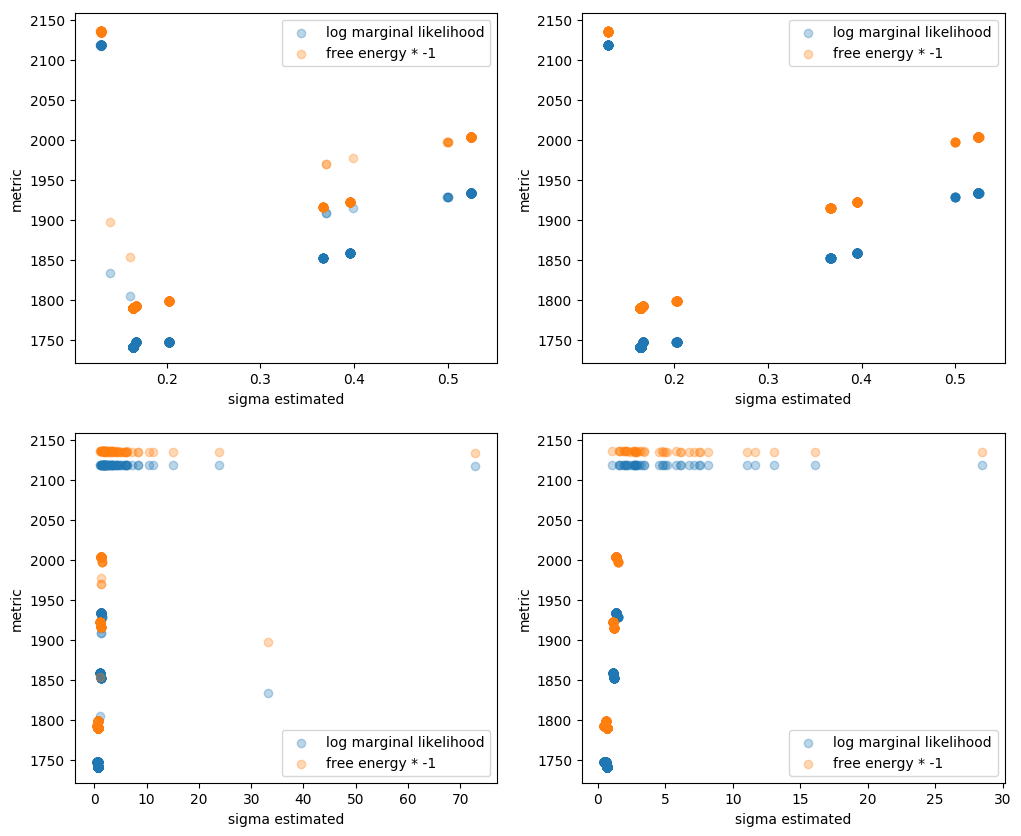

PyObject <matplotlib.legend.Legend object at 0x134803e10>

In [14]:
nrow, ncol = (2, 2)
fig, axe = subplots(nrow, ncol, figsize=(12, 10))

axe[1, 1][:scatter](sim_one[:sigma_results][:, 1], sim_one_lf[:lml], alpha=.3)
axe[1, 1][:set_xlabel]("sigma estimated")
axe[1, 1][:set_ylabel]("metric")
axe[1, 1][:scatter](sim_one[:sigma_results][:, 1], sim_one_lf[:fe].*-1, alpha=.3)
axe[1, 1][:legend](["log marginal likelihood", "free energy * -1"])

axe[2, 1][:scatter](sim_one[:sigma_results][:, 2], sim_one_lf[:lml], alpha=.3)
axe[2, 1][:set_xlabel]("sigma estimated")
axe[2, 1][:set_ylabel]("metric")
axe[2, 1][:scatter](sim_one[:sigma_results][:, 2], sim_one_lf[:fe].*-1, alpha=.3)
axe[2, 1][:legend](["log marginal likelihood", "free energy * -1"])


# sim 2
axe[1, 2][:scatter](sim_two[:sigma_results][:, 1], sim_two_lf[:lml], alpha=.3)
axe[1, 2][:set_xlabel]("sigma estimated")
axe[1, 2][:set_ylabel]("metric")
axe[1, 2][:scatter](sim_two[:sigma_results][:, 1], sim_two_lf[:fe].*-1, alpha=.3)
axe[1, 2][:legend](["log marginal likelihood", "free energy * -1"])

axe[2, 2][:scatter](sim_two[:sigma_results][:, 2], sim_two_lf[:lml], alpha=.3)
axe[2, 2][:set_xlabel]("sigma estimated")
axe[2, 2][:set_ylabel]("metric")
axe[2, 2][:scatter](sim_two[:sigma_results][:, 2], sim_two_lf[:fe].*-1, alpha=.3)
axe[2, 2][:legend](["log marginal likelihood", "free energy * -1"])

# plotting histograms of estimated beta and sigma values

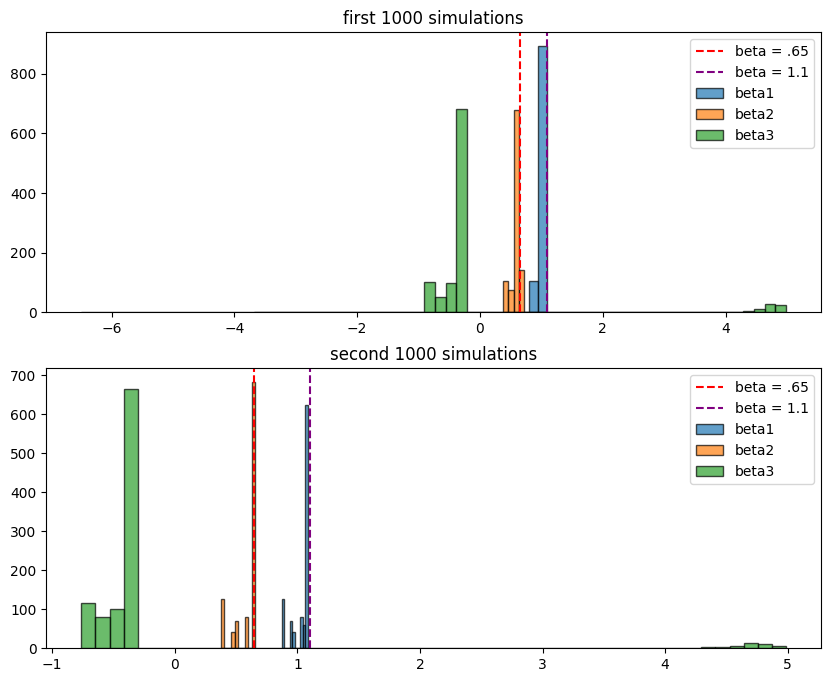

PyObject Text(0.5,1,u'second 1000 simulations')

In [49]:
nrow, ncol = (2, 1)
fig, axe = subplots(nrow, ncol, figsize=(10, 8))
axe[1, 1][:hist](sim_one[:beta_results][:, 1], bins=50, edgecolor="black", alpha=.7)
axe[1, 1][:hist](sim_one[:beta_results][:, 2], bins=50, edgecolor="black", alpha=.7)
axe[1, 1][:hist](sim_one[:beta_results][:, 3], bins=50, edgecolor="black", alpha=.7)
axe[1, 1][:axvline](.65, ls="--", color="red")
axe[1, 1][:axvline](1.1, ls="--", color="purple")
axe[1,1][:legend](["beta = .65", "beta = 1.1", "beta1", "beta2", "beta3"])
axe[1, 1][:set_title]("first 1000 simulations")

axe[2, 1][:hist](sim_two[:beta_results][:, 1], edgecolor="black", alpha=.7)
axe[2, 1][:hist](sim_two[:beta_results][:, 2],  edgecolor="black", alpha=.7)
axe[2, 1][:hist](sim_two[:beta_results][:, 3], bins=50, edgecolor="black", alpha=.7)
axe[2, 1][:axvline](.65, ls="--", color="red")
axe[2, 1][:axvline](1.1, ls="--", color="purple")
axe[2,1][:legend](["beta = .65", "beta = 1.1", "beta1", "beta2", "beta3"])
axe[2, 1][:set_title]("second 1000 simulations")

# trying to zone in on the "better" betas